<a href="https://colab.research.google.com/github/xdr100/5241HW/blob/main/5241NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Don't forget to enable GPU:    
Edit > Notebook settings or Runtime>Change runtime type    
and select GPU as Hardware accelerator.

In [42]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tq
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from google.colab import files
from imblearn.over_sampling import SMOTE
from collections import Counter
import statistics

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import Data

In [43]:
#url of the dataset from our GitHub repository
url_red="https://raw.githubusercontent.com/JMGilbert/STAT4241-Final-Project/main/winequality-red.csv"
url_white="https://raw.githubusercontent.com/JMGilbert/STAT4241-Final-Project/main/winequality-white.csv"
red=pd.read_csv(url_red,sep=';')
white=pd.read_csv(url_white,sep=';')

<BarContainer object of 7 artists>

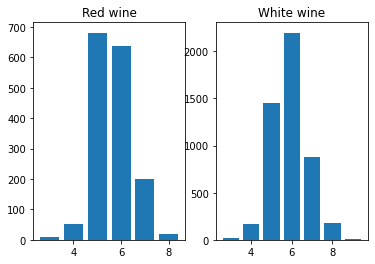

In [44]:
plt.subplot(1,2,1).set_title("Red wine")
plt.bar(list(set(red["quality"])),red["quality"].value_counts(sort=False).sort_index())
plt.subplot(1,2,2).set_title("White wine")
plt.bar(list(set(white["quality"])),white["quality"].value_counts(sort=False).sort_index())

In [45]:
print(white.isnull().values.any())
print(red.isnull().values.any())

False
False


In [46]:
X_white=white.loc[:, white.columns != 'quality']
Y_white=white.loc[:, white.columns == 'quality']
X_red=red.loc[:, red.columns != 'quality']
Y_red=red.loc[:, red.columns == 'quality']

In [47]:
def TO_TORCH(m):
    #convert an array/DF into a tensor with gpu on if necessary
    if isinstance(m, np.ndarray):
        m=torch.from_numpy(m).float()
    elif isinstance(m, pd.DataFrame):
        m=torch.from_numpy(m.values).float()
    elif isinstance(m, pd.Series):
        m=torch.from_numpy(m.values).float()

    if train_on_gpu:
        m = m.to(device="cuda")
    return(m)

In [48]:
red_class=pd.unique(red['quality'])
white_class=pd.unique(white['quality'])
red_class.sort()
white_class.sort()

In [49]:
predictors_name=list(red.columns)[:-1]
predictors_name

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

# !STRATIFY! $\frac{2}{3}$/$\frac{1}{3}$ Holdout Split and Standardization


In [50]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(X_white, Y_white['quality'], test_size=0.33, random_state=42,stratify=Y_white['quality']) #24
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(X_red, Y_red['quality'], test_size=0.33, random_state=42,stratify=Y_red["quality"])


In [51]:
print(Counter(Y_TRAIN_white))
print(Counter(Y_TEST_white))
print(Counter(Y_TRAIN_red))
print(Counter(Y_TEST_red))

Counter({6: 1472, 5: 976, 7: 590, 8: 117, 4: 109, 3: 14, 9: 3})
Counter({6: 726, 5: 481, 7: 290, 8: 58, 4: 54, 3: 6, 9: 2})
Counter({5: 456, 6: 427, 7: 133, 4: 36, 8: 12, 3: 7})
Counter({5: 225, 6: 211, 7: 66, 4: 17, 8: 6, 3: 3})


In [52]:
TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)

# Nerual Networks

## Architecture

? why using one dimensional output 

In [53]:
# Neural Network structure
class Net(nn.Module):
    def __init__(self,INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM,DROP_PR,BN=False):
        super(Net, self).__init__()
        self.input_dim = INPUT_DIM
        self.output_dim = OUTPUT_DIM
        self.hidden_dim = HIDDEN_DIM
        self.DROP_PR = DROP_PR
        current_dim = self.input_dim
        self.layers = nn.ModuleList()
        self.BN=BN
        self.bn = nn.ModuleList()
        for hdim in self.hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            self.bn.append(nn.BatchNorm1d(hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, self.output_dim))
        self.dropout = nn.Dropout(DROP_PR) #self.DROP_PR

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.BN:
                x = self.bn[i](x)
            #x = torch.sigmoid(x)
            x = F.relu(x)
            x = self.dropout(x)
        out = self.layers[-1](x)
        return out 

#Loss function: mean absolute deviation
#criterion = torch.nn.L1Loss() 
criterion = torch.nn.MSELoss()

#Accuracy with tolerance
def ACCURACY(Y_pred,target,Tolerance):
    v=(abs(Y_pred-target)<=Tolerance)*1.0
    return(torch.mean(v))

#Kappa statistic compared with a random classifier
def KAPPA(Y_pred,target):
    #only work for Tolerance=0.5
    KAPP=cohen_kappa_score(target.cpu().detach().numpy(),torch.round(Y_pred).cpu().detach().numpy())
    #KAPP2=cohen_kappa_score(torch.round(Y_pred).cpu().detach().numpy(),target.cpu().detach().numpy())    
    return(KAPP)

## Wrap it up

In [54]:
def TEST_NN(MODEL,TEST_X,TEST_Y,T_list=[0.25,0.5,1]):
    MODEL.eval()
    test_pred=MODEL(TEST_X)[:,0]
    loss = criterion(test_pred, TEST_Y)
    L2=loss.item()
    accuracy_list=[ACCURACY(test_pred,TEST_Y,T).item() for T in T_list]
    kappa=KAPPA(test_pred, TEST_Y)
    MODEL.train()
    return({"L2":L2,"accuracy_list":accuracy_list,"kappa":kappa})

In [55]:
def TRAIN_NN(TRAIN_X,TRAIN_Y,TEST_X,TEST_Y,HIDDEN_DIM,EPOCH,DROP_PR=0.0,BN=False,LR=1e-2,OPT="SGD",T=1,STEP_SIZE=50000,DECAY=0.1,seed=0):
    #TRAIN_X,TRIAN_Y: should be tensors
    # HIDDEN_DIM: [H] or deeper
    # BN: Bool, if using Batch Normalization or not
    # "SGD" or "ADAM"
    # T:0.25,0.5,1.0
    torch.manual_seed(seed)
    INPUT_DIM = TRAIN_X.shape[1]
    OUTPUT_DIM = 1
    MODEL=Net(INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM,DROP_PR,BN)
    if train_on_gpu:
        MODEL.cuda()
    #Optimizer: 
    if OPT=="SGD":
        optimizer = torch.optim.SGD(MODEL.parameters(),lr=LR)
    if OPT=="ADAM":
        optimizer = torch.optim.Adam(MODEL.parameters(),lr=LR, betas=(0.9, 0.99))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=DECAY)
    LOSS_ARR=[]
    LOSS_validation=[]
    ACC_TRAIN_LIST=[]
    ACC_VALIDATION_LIST=[]
    #for epoch in tq(range(EPOCH)):
    for epoch in range(EPOCH):
        optimizer.zero_grad()
        outputs=MODEL(TRAIN_X)[:,0] #prediction
        loss = criterion(outputs, TRAIN_Y) #compared with the true labels
        LOSS_ARR.append(loss.data)
        loss.backward()
        optimizer.step() 
        scheduler.step() 
        Result_TEST=TEST_NN(MODEL,TEST_X,TEST_Y,[T])
        LOSS_validation.append(Result_TEST["L2"]) 
        ACC_VALIDATION_LIST.append(Result_TEST["accuracy_list"][0]) 
        ACC_TRAIN_LIST.append(ACCURACY(outputs,TRAIN_Y,T).item())
        if (epoch+1)%round(EPOCH/5)==0:
            #kappa=KAPPA(outputs, TRAIN_Y)
            accuracy=ACCURACY(outputs,TRAIN_Y,T).item()
            print("After {} Epochs:".format((epoch+1)))
            print("Train Loss is {}; Train Accuracy is {}% (T={});".format(round(loss.item(),4),round(accuracy*100,4),T))
            print("Test Loss is {}; Test Accuracy is {}% (T={});".format(round(Result_TEST["L2"],4),round(Result_TEST["accuracy_list"][0]*100,4),T))
        
    return({"MODEL":MODEL,"LOSS_TRAIN":LOSS_ARR,"LOSS_VALIDATION":LOSS_validation,
            "ACCURACY_TRAIN":ACC_TRAIN_LIST,"ACCURACY_VALIDATION":ACC_VALIDATION_LIST})

### White wine

#### ADAM

In [56]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,X_TEST_white,Y_TEST_white,[8],OPT="ADAM",LR=1e-3,DROP_PR=0.8,BN=True,STEP_SIZE=10000,DECAY=0.5,EPOCH=60000,seed=233)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_TRAIN"]
LOSS_validation_white=result_white["LOSS_VALIDATION"]

After 12000 Epochs:
Train Loss is 0.6809; Train Accuracy is 81.0119% (T=1);
Test Loss is 0.6308; Test Accuracy is 83.859% (T=1);
After 24000 Epochs:
Train Loss is 0.6821; Train Accuracy is 80.4937% (T=1);
Test Loss is 0.6319; Test Accuracy is 83.7353% (T=1);
After 36000 Epochs:
Train Loss is 0.6621; Train Accuracy is 81.3167% (T=1);
Test Loss is 0.6321; Test Accuracy is 83.859% (T=1);
After 48000 Epochs:
Train Loss is 0.672; Train Accuracy is 81.1948% (T=1);
Test Loss is 0.6314; Test Accuracy is 83.7353% (T=1);
After 60000 Epochs:
Train Loss is 0.6753; Train Accuracy is 81.53% (T=1);
Test Loss is 0.6316; Test Accuracy is 83.7353% (T=1);


Text(0.5, 1.0, 'Final Train Loss = 0.6753166913986206 \n Final Validation Loss = 0.6316317319869995')

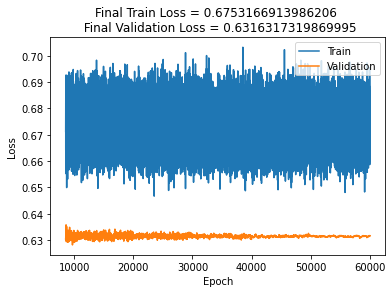

In [57]:
zoom=np.floor(len(LOSS_white)/7).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_white)-zoom)+zoom, LOSS_white[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_white)-zoom)+zoom, LOSS_validation_white[zoom:],label="Validation")

#plt.plot((np.arange(len(LOSS_validation_white))+1)*len(LOSS_white)-1, LOSS_validation_white,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Final Train Loss = {} \n Final Validation Loss = {}".format(LOSS_white[-1],LOSS_validation_white[-1]))

In [58]:
T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test Loss is {};".format(round(Result_TEST_white["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test Loss is 0.632;
Test Accuracy is 22.263% (T=0.25);
Test Accuracy is 45.455% (T=0.5);
Test Accuracy is 83.735% (T=1);
Test KAPPA is 1.724% (T=0.5);


#### SGD

In [59]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,X_TEST_white,Y_TEST_white,[9],OPT="SGD",LR=1e-1/2,DROP_PR=0.0,BN=False,STEP_SIZE=10000,DECAY=0.5,EPOCH=60000,seed=24)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_TRAIN"]
LOSS_validation_white=result_white["LOSS_VALIDATION"]
ACCURACY_WHITE_TRAIN=result_white["ACCURACY_TRAIN"]
ACCURACY_WHITE_VALIDATION=result_white["ACCURACY_VALIDATION"]

After 12000 Epochs:
Train Loss is 0.4708; Train Accuracy is 87.3819% (T=1);
Test Loss is 0.5054; Test Accuracy is 85.4051% (T=1);
After 24000 Epochs:
Train Loss is 0.4684; Train Accuracy is 87.8391% (T=1);
Test Loss is 0.5067; Test Accuracy is 85.3432% (T=1);
After 36000 Epochs:
Train Loss is 0.4663; Train Accuracy is 87.9% (T=1);
Test Loss is 0.5077; Test Accuracy is 85.4669% (T=1);
After 48000 Epochs:
Train Loss is 0.4658; Train Accuracy is 87.9305% (T=1);
Test Loss is 0.5077; Test Accuracy is 85.3432% (T=1);
After 60000 Epochs:
Train Loss is 0.4655; Train Accuracy is 87.9915% (T=1);
Test Loss is 0.5079; Test Accuracy is 85.2195% (T=1);


Text(0.5, 1.0, 'White Wine \n Final Train Accuracy (T=1) = 87.991% \n Final Validation Accuracy (T=1) = 85.220%')

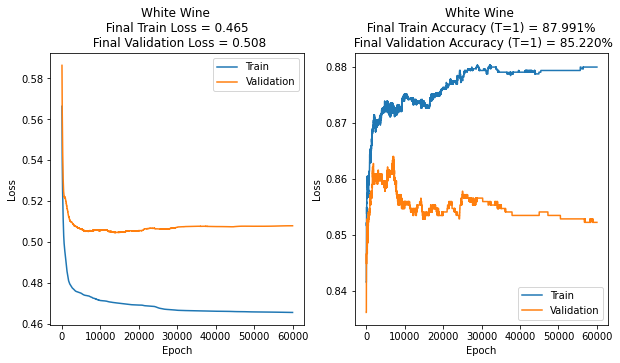

In [60]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
zoom=np.floor(len(LOSS_white)/900).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_white)-zoom)+zoom, LOSS_white[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_white)-zoom)+zoom, LOSS_validation_white[zoom:],label="Validation")

#plt.plot((np.arange(len(LOSS_validation_white))+1)*len(LOSS_white)-1, LOSS_validation_white,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("White Wine \n Final Train Loss = {:.3f} \n Final Validation Loss = {:.3f}".format(LOSS_white[-1],LOSS_validation_white[-1]))

plt.subplot(1,2,2)
zoom=np.floor(len(ACCURACY_WHITE_TRAIN)/900).astype(int)
#zoom=0
plt.plot(np.arange(len(ACCURACY_WHITE_TRAIN)-zoom)+zoom, ACCURACY_WHITE_TRAIN[zoom:],label="Train")
plt.plot(np.arange(len(ACCURACY_WHITE_VALIDATION)-zoom)+zoom, ACCURACY_WHITE_VALIDATION[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("White Wine \n Final Train Accuracy (T=1) = {:.3f}% \n Final Validation Accuracy (T=1) = {:.3f}%".format(100*ACCURACY_WHITE_TRAIN[-1],100*ACCURACY_WHITE_VALIDATION[-1]))

#plt.savefig("white train.png", bbox_inches='tight')
#files.download("white train.png")

In [61]:
T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test Loss is {};".format(round(Result_TEST_white["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test Loss is 0.508;
Test Accuracy is 26.778% (T=0.25);
Test Accuracy is 54.793% (T=0.5);
Test Accuracy is 85.22% (T=1);
Test KAPPA is 28.24% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

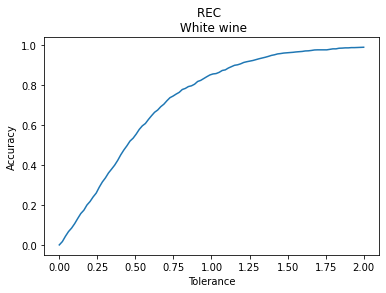

In [62]:
T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

In [63]:
print(Counter(Y_TEST_white.cpu().numpy()))
print(Counter(Y_TRAIN_white.cpu().numpy()))

Counter({6.0: 726, 5.0: 481, 7.0: 290, 8.0: 58, 4.0: 54, 3.0: 6, 9.0: 2})
Counter({6.0: 1472, 5.0: 976, 7.0: 590, 8.0: 117, 4.0: 109, 3.0: 14, 9.0: 3})


### Red wine

HIDDEN=[9],LR=1e-1/2,DROP_PR=0.0,STEP_SIZE=50000,DECAY=0.5,EPOCH=60000,seed=233

In [64]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,X_TEST_red,Y_TEST_red,[9],LR=1e-1/2,OPT="SGD",DROP_PR=0.0,BN=False,STEP_SIZE=30000,DECAY=0.5,EPOCH=100000,seed=18)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_TRAIN"]
LOSS_validation_red=result_red["LOSS_VALIDATION"]
ACCURACY_RED_TRAIN=result_red["ACCURACY_TRAIN"]
ACCURACY_RED_VALIDATION=result_red["ACCURACY_VALIDATION"]

After 20000 Epochs:
Train Loss is 0.3044; Train Accuracy is 92.5303% (T=1);
Test Loss is 0.4417; Test Accuracy is 86.9318% (T=1);
After 40000 Epochs:
Train Loss is 0.3027; Train Accuracy is 92.5303% (T=1);
Test Loss is 0.4437; Test Accuracy is 86.553% (T=1);
After 60000 Epochs:
Train Loss is 0.3023; Train Accuracy is 92.5303% (T=1);
Test Loss is 0.4438; Test Accuracy is 86.3636% (T=1);
After 80000 Epochs:
Train Loss is 0.3021; Train Accuracy is 92.5303% (T=1);
Test Loss is 0.4441; Test Accuracy is 86.3636% (T=1);
After 100000 Epochs:
Train Loss is 0.3017; Train Accuracy is 92.5303% (T=1);
Test Loss is 0.4437; Test Accuracy is 86.3636% (T=1);


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

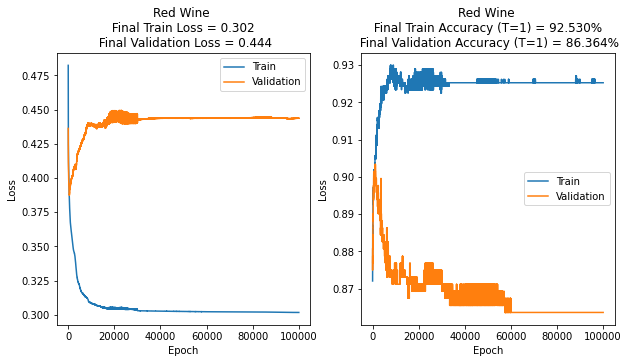

In [65]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
zoom=np.floor(len(LOSS_red)/3000).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_red)-zoom)+zoom, LOSS_red[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_red)-zoom)+zoom, LOSS_validation_red[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Red Wine \n Final Train Loss = {:.3f} \n Final Validation Loss = {:.3f}".format(LOSS_red[-1],LOSS_validation_red[-1]))

plt.subplot(1,2,2)
zoom=np.floor(len(ACCURACY_RED_TRAIN)/3000).astype(int)
#zoom=0
plt.plot(np.arange(len(ACCURACY_RED_TRAIN)-zoom)+zoom, ACCURACY_RED_TRAIN[zoom:],label="Train")
plt.plot(np.arange(len(ACCURACY_RED_VALIDATION)-zoom)+zoom, ACCURACY_RED_VALIDATION[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Red Wine \n Final Train Accuracy (T=1) = {:.3f}% \n Final Validation Accuracy (T=1) = {:.3f}%".format(100*ACCURACY_RED_TRAIN[-1],100*ACCURACY_RED_VALIDATION[-1]))

plt.savefig("red train drop 100000.png", bbox_inches='tight')
files.download("red train drop 100000.png")

In [66]:
T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test Loss is {};".format(round(Result_TEST_red["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test Loss is 0.444;
Test Accuracy is 30.682% (T=0.25);
Test Accuracy is 57.765% (T=0.5);
Test Accuracy is 86.364% (T=1);
Test KAPPA is 31.758% (T=0.5);


Text(0.5, 1.0, 'REC \n Red wine')

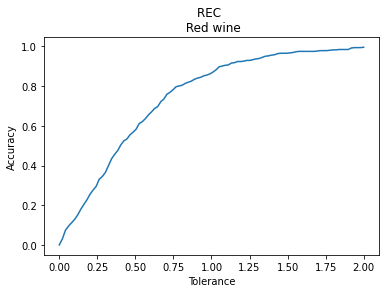

In [67]:
T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n Red wine")

#  Sensitivity Analysis 
!“correlation does not equal causation.”

In [68]:
p=X_TRAIN_red.shape[1] #11

In [69]:
def Sensitivity_Analysis(MODEL,a,L=6):
    #a: indicator of the predictor, a=0,1,2,...10(p-1)
    MODEL.eval()
    Analysis_X=torch.zeros((L,p))
    Analysis_X[:,(a)]=torch.from_numpy(np.linspace(-1, 1, 6, endpoint=True))
    if train_on_gpu:
        Analysis_X=Analysis_X.to(device="cuda")
    result=MODEL(Analysis_X).var()
    MODEL.train()
    return result.cpu().detach().numpy()

In [70]:
V_red=np.zeros(p)
for a in range(p):
  V_red[a]=(Sensitivity_Analysis(MODEL_NN_red,a))
R_red=V_red/V_red.sum()*100
#R_red=pd.DataFrame(R_red,index=predictors_name)

V_white=np.zeros(p)
for a in range(p):
  V_white[a]=(Sensitivity_Analysis(MODEL_NN_white,a))
R_white=V_white/V_white.sum()*100
#R_white=pd.DataFrame(R_white,index=predictors_name)
R=pd.DataFrame({"red":R_red,"white":R_white}, index=predictors_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x720 with 0 Axes>

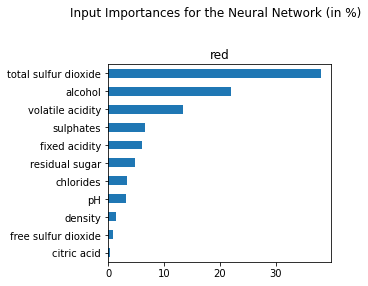

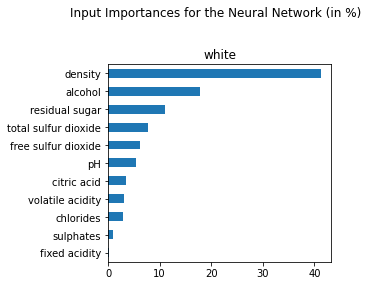

In [71]:
plt.figure(figsize=(10,10))
R.sort_values(by="red").plot.barh(y='red',legend=None,subplots=True, layout=(2,1),figsize=(4,8),title="Input Importances for the Neural Network (in %)")

plt.savefig("sensi red.png", bbox_inches='tight')
files.download("sensi red.png")
R.sort_values(by="white").plot.barh(y='white',legend=None,subplots=True, layout=(2,1),figsize=(4,8),title="Input Importances for the Neural Network (in %)")

plt.savefig("sensi white.png", bbox_inches='tight')
files.download("sensi white.png")

# the Problem of Imbalance Data

In [72]:
for i,c in enumerate(red_class):
    print("there are {} red wine samples with the score of {}".format(len(Y_red_torch[Y_red_torch==red_class[i]]),c))
print("\n")
for i,c in enumerate(white_class):
    print("there are {} white wine samples with the score of {}".format(len(Y_white_torch[Y_white_torch==white_class[i]]),c))
   

there are 10 red wine samples with the score of 3
there are 53 red wine samples with the score of 4
there are 681 red wine samples with the score of 5
there are 638 red wine samples with the score of 6
there are 199 red wine samples with the score of 7
there are 18 red wine samples with the score of 8


there are 20 white wine samples with the score of 3
there are 163 white wine samples with the score of 4
there are 1457 white wine samples with the score of 5
there are 2198 white wine samples with the score of 6
there are 880 white wine samples with the score of 7
there are 175 white wine samples with the score of 8
there are 5 white wine samples with the score of 9


In [73]:
counter=Counter(Y_white_torch.cpu().numpy()[:,0])
count_white=[str(len(Y_white_torch[Y_white_torch==white_class[i]])) for i,c in enumerate(white_class)]
percentage_white=[100*round(counter[i] /len(Y_white_torch.cpu().numpy()),3) for i in white_class] 
white_m=pd.DataFrame([count_white,percentage_white]).transpose()
white_m=white_m.set_index(white_class)
white_m.columns=["Bottle of White Wine","%"]

total=pd.DataFrame(index=["Total"],columns=["Bottle of White Wine","%"])
total.at["Total","Bottle of White Wine"] = len(Y_white_torch.cpu().numpy() )
total.at["Total","%"] = 100

white_m.append(total)

,Bottle of White Wine,%
3,20,0.4
4,163,3.3
5,1457,29.7
6,2198,44.9
7,880,18
8,175,3.6
9,5,0.1
Total,4898,100


In [74]:
counter=Counter(Y_red_torch.cpu().numpy()[:,0])
count_red=[str(len(Y_red_torch[Y_red_torch==red_class[i]])) for i,c in enumerate(red_class)]
percentage_red=[100*round(counter[i] /len(Y_red_torch.cpu().numpy() ),3) for i in red_class] 
red_m=pd.DataFrame([count_red,percentage_red]).transpose()
red_m=red_m.set_index(red_class)
red_m.columns=["Bottle of Red Wine","%"]

total=pd.DataFrame(index=["Total"],columns=["Bottle of Red Wine","%"])
total.at["Total","Bottle of Red Wine"] = len(Y_red_torch.cpu().numpy() )
total.at["Total","%"] = 100

red_m.append(total)

,Bottle of Red Wine,%
3,10,0.6
4,53,3.3
5,681,42.6
6,638,39.9
7,199,12.4
8,18,1.1
Total,1599,100


In [75]:
from scipy import stats
#Kullback-Leibler divergence from the uniform distribution
stats.entropy(percentage_red,[1/len(red_class)]*len(red_class))

0.6097432644827808

## Confusion Matrix T=0.5
Using the full data

>??? suppose T=0.5, and the predicted value is 2.5, which column of confusion matrix should we add it to, 2 or 3??

In [76]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())[:,0] 
red_pred=np.where(red_pred >=8.0, 8, red_pred)
red_pred=np.where(red_pred <=3.0, 3, red_pred)  
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
print("Confusion Matrix for Red Wine (T=0.5)")
red_confusion.loc['Total']= red_confusion.sum()
red_confusion['Total'] = red_confusion.sum(axis=1)
red_confusion 


Confusion Matrix for Red Wine (T=0.5)


,3,4,5,6,7,8,Total
3,0,4,5,1,0,0,10
4,1,7,40,5,0,0,53
5,0,8,508,163,2,0,681
6,0,2,171,419,46,0,638
7,0,0,10,91,98,0,199
8,0,0,0,4,14,0,18
Total,1,21,734,683,160,0,1599


In [77]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())[:,0] 
white_pred=np.where(white_pred >=8.0, 8, white_pred)
white_pred=np.where(white_pred <=3.0, 3, white_pred)    
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
print("Confusion Matrix for White Wine (T=0.5)")
white_confusion.loc['Total']= white_confusion.sum()
white_confusion['Total'] = white_confusion.sum(axis=1)
white_confusion 

Confusion Matrix for White Wine (T=0.5)


,3,4,5,6,7,8,9,Total
3,0,1,9,10,0,0,0,20
4,0,15,105,42,1,0,0,163
5,0,8,757,677,15,0,0,1457
6,0,1,359,1585,253,0,0,2198
7,0,0,15,531,331,3,0,880
8,0,0,1,81,92,1,0,175
9,0,0,0,1,4,0,0,5
Total,0,25,1246,2927,696,4,0,4898


using the test data

In [78]:
red_pred=np.round(MODEL_NN_red(X_TEST_red).cpu().detach().numpy())   
red_confusion=confusion_matrix(Y_TEST_red.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
red_confusion  

,3,4,5,6,7,8
3,0,0,2,1,0,0
4,1,1,12,3,0,0
5,0,3,151,69,2,0
6,0,2,70,125,14,0
7,0,0,6,31,28,1
8,0,0,0,2,4,0


In [80]:
white_pred=np.round(MODEL_NN_white(X_TEST_white).cpu().detach().numpy())   
white_confusion=confusion_matrix(Y_TEST_white.cpu().detach().numpy(), white_pred)
#white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
white_confusion 

,3,4,5,6,7,8,9
3,0,0,2,4,0,0,0
4,0,4,39,11,0,0,0
5,0,5,237,233,6,0,0
6,0,1,118,530,77,0,0
7,0,0,7,166,115,2,0
8,0,0,1,28,29,0,0
9,0,0,0,1,1,0,0


None of the 9-point wine in the test dataset!   
In the test dataset, one of the 3-point wine is classified as 8!

## Kappa statistics

In [81]:
Result_TEST_white=TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list)
Result_TEST_red=TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list)
test_kappa_red=Result_TEST_red["kappa"]
#print("KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))
test_kappa_white=Result_TEST_white["kappa"]
#print("KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))
kappadf=pd.DataFrame([test_kappa_red,test_kappa_white]).transpose()
kappadf.columns=["Red","White"]
print("Kappa statistics (T=0.5):")
kappadf

Kappa statistics (T=0.5):


,Red,White
0,0.429155,0.28461


## Precision for the different classes

using the full data

In [82]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    predictor=X_red_torch[(Y_red_torch==red_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[1.0])["accuracy_list"][0]
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2

print("Precision for different classes \n (Red Wine)")
red_precision.append(overall)

Precision for different classes 
 (Red Wine)


,T=0.5 (%),T=1.0 (%)
3,0,10
4,13.2075,45.283
5,74.5962,95.7416
6,65.674,97.1787
7,49.2462,76.8844
8,0,22.2222
Overall,64.5403,90.9318


In [83]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    predictor=X_white_torch[(Y_white_torch==white_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[1.0])["accuracy_list"][0]
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2
print("Precision for different classes \n (White Wine)")

white_precision.append(overall)

Precision for different classes 
 (White Wine)


,T=0.5 (%),T=1.0 (%)
3,0,0
4,9.20245,42.3313
5,51.9561,90.5285
6,72.111,97.8617
7,37.6136,80.3409
8,0.571429,12
9,0,0
Overall,54.9,87.1172


# To fix the Problem of Imbalance data: SMOTE
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/   
  
N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal Of Artificial Intelligence Research, Volume 16, pages 321-357.
 

Using the syntheric dataset for the training/testing   
Using the original dataset to get the confusion matrices and the precision

In [84]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import statistics

## resample only the minority class 

Need to decide the size of oversampling

?? underfitting?

### Max

In [118]:
counter = Counter(Y_white["quality"])
print(counter)
Max=max(counter.values()) #2198
sm = SMOTE(sampling_strategy={3:Max,9:Max},random_state=24,k_neighbors=4)
Augmented_X_white,Augmented_Y_white=sm.fit_sample(X_white, Y_white["quality"])
counter = Counter(Augmented_Y_white)
print(counter)

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})
Counter({6: 2198, 3: 2198, 9: 2198, 5: 1457, 7: 880, 8: 175, 4: 163})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [119]:
counter = Counter(Y_red["quality"])
print(counter)
Max=max(counter.values()) 
sm = SMOTE(sampling_strategy={3:Max,8:Max,4:Max},random_state=24,k_neighbors=4)
Augmented_X_red,Augmented_Y_red=sm.fit_sample(X_red, Y_red["quality"])
counter = Counter(Augmented_Y_red)
print(counter)

Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
Counter({5: 681, 4: 681, 8: 681, 3: 681, 6: 638, 7: 199})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [120]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(Augmented_X_white, Augmented_Y_white, test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(Augmented_X_red, Augmented_Y_red, test_size=0.33, random_state=42)
#X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(X_white, Y_white['quality'], test_size=0.33, random_state=42,stratify=Y_white['quality']) #24
#X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(X_red, Y_red['quality'], test_size=0.33, random_state=42,stratify=Y_red["quality"])


TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

"""scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)"""

'scaler_white = preprocessing.StandardScaler().fit(X_white)\nscaler_red = preprocessing.StandardScaler().fit(X_red)\nX_white_torch = TO_TORCH(scaler_white.transform(X_white))\nX_red_torch = TO_TORCH(scaler_red.transform(X_red))\nY_white_torch = TO_TORCH(Y_white)\nY_red_torch = TO_TORCH(Y_red)'

After 12000 Epochs:
Train Loss is 0.8135; Train Accuracy is 77.6006% (T=1);
Test Loss is 0.8845; Test Accuracy is 74.5015% (T=1);
After 24000 Epochs:
Train Loss is 0.7375; Train Accuracy is 79.4042% (T=1);
Test Loss is 0.8188; Test Accuracy is 76.3975% (T=1);
After 36000 Epochs:
Train Loss is 0.7223; Train Accuracy is 79.4686% (T=1);
Test Loss is 0.8011; Test Accuracy is 76.4956% (T=1);
After 48000 Epochs:
Train Loss is 0.7194; Train Accuracy is 79.4847% (T=1);
Test Loss is 0.7973; Test Accuracy is 76.4956% (T=1);
After 60000 Epochs:
Train Loss is 0.7215; Train Accuracy is 79.4847% (T=1);
Test Loss is 0.7995; Test Accuracy is 76.2668% (T=1);
Test Loss is 0.8;
Test Accuracy is 24.91% (T=0.25);
Test Accuracy is 51.259% (T=0.5);
Test Accuracy is 76.267% (T=1);
Test KAPPA is 41.998% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

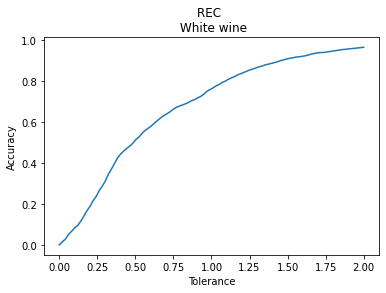

In [121]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,X_TEST_white,Y_TEST_white,[9],LR=1e-1/2,BN=False,STEP_SIZE=100000,DECAY=0.5,EPOCH=60000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_TRAIN"]
LOSS_validation_white=result_white["LOSS_VALIDATION"]
ACCURACY_WHITE_TRAIN=result_white["ACCURACY_TRAIN"]
ACCURACY_WHITE_VALIDATION=result_white["ACCURACY_VALIDATION"]

T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test Loss is {};".format(round(Result_TEST_white["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

Text(0.5, 1.0, 'White Wine \n Final Train Accuracy (T=1) = 79.485% \n Final Validation Accuracy (T=1) = 76.267%')

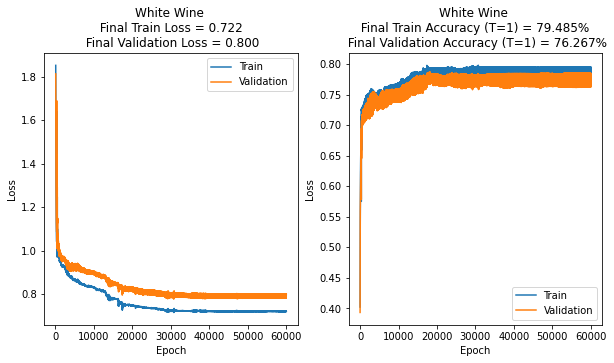

In [122]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
zoom=np.floor(len(LOSS_white)/900).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_white)-zoom)+zoom, LOSS_white[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_white)-zoom)+zoom, LOSS_validation_white[zoom:],label="Validation")

#plt.plot((np.arange(len(LOSS_validation_white))+1)*len(LOSS_white)-1, LOSS_validation_white,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("White Wine \n Final Train Loss = {:.3f} \n Final Validation Loss = {:.3f}".format(LOSS_white[-1],LOSS_validation_white[-1]))

plt.subplot(1,2,2)
zoom=np.floor(len(ACCURACY_WHITE_TRAIN)/9000).astype(int)
#zoom=0
plt.plot(np.arange(len(ACCURACY_WHITE_TRAIN)-zoom)+zoom, ACCURACY_WHITE_TRAIN[zoom:],label="Train")
plt.plot(np.arange(len(ACCURACY_WHITE_VALIDATION)-zoom)+zoom, ACCURACY_WHITE_VALIDATION[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("White Wine \n Final Train Accuracy (T=1) = {:.3f}% \n Final Validation Accuracy (T=1) = {:.3f}%".format(100*ACCURACY_WHITE_TRAIN[-1],100*ACCURACY_WHITE_VALIDATION[-1]))


After 20000 Epochs:
Train Loss is 0.3663; Train Accuracy is 90.4822% (T=1);
Test Loss is 0.5054; Test Accuracy is 86.1395% (T=1);
After 40000 Epochs:
Train Loss is 0.3663; Train Accuracy is 90.5241% (T=1);
Test Loss is 0.5051; Test Accuracy is 86.1395% (T=1);
After 60000 Epochs:
Train Loss is 0.3663; Train Accuracy is 90.5241% (T=1);
Test Loss is 0.5051; Test Accuracy is 86.1395% (T=1);
After 80000 Epochs:
Train Loss is 0.3663; Train Accuracy is 90.5241% (T=1);
Test Loss is 0.5052; Test Accuracy is 86.1395% (T=1);
After 100000 Epochs:
Train Loss is 0.3663; Train Accuracy is 90.5241% (T=1);
Test Loss is 0.5051; Test Accuracy is 86.1395% (T=1);
Test Loss is 0.505;
Test Accuracy is 35.799% (T=0.25);
Test Accuracy is 63.01% (T=0.5);
Test Accuracy is 86.139% (T=1);
Test KAPPA is 55.019% (T=0.5);


Text(0.5, 1.0, 'REC \n Red wine')

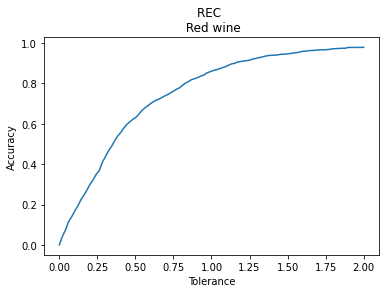

In [123]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,X_TEST_red,Y_TEST_red,[9],LR=1e-1/2,OPT="SGD",DROP_PR=0.0,BN=False,STEP_SIZE=30000,DECAY=0.5,EPOCH=100000,seed=233)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_TRAIN"]
LOSS_validation_red=result_red["LOSS_VALIDATION"]
ACCURACY_RED_TRAIN=result_red["ACCURACY_TRAIN"]
ACCURACY_RED_VALIDATION=result_red["ACCURACY_VALIDATION"]

T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test Loss is {};".format(round(Result_TEST_red["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))


T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n Red wine")

Text(0.5, 1.0, 'Red Wine \n Final Train Accuracy (T=1) = 90.524% \n Final Validation Accuracy (T=1) = 86.139%')

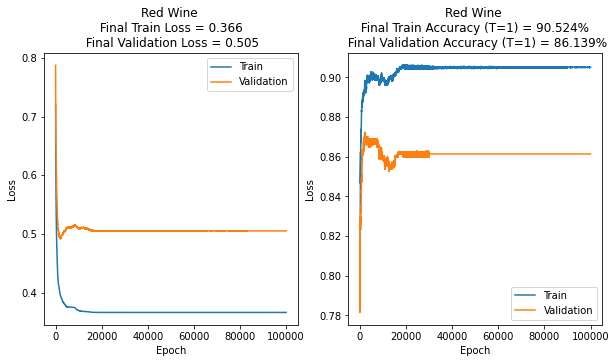

In [124]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
zoom=np.floor(len(LOSS_red)/3000).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_red)-zoom)+zoom, LOSS_red[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_red)-zoom)+zoom, LOSS_validation_red[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Red Wine \n Final Train Loss = {:.3f} \n Final Validation Loss = {:.3f}".format(LOSS_red[-1],LOSS_validation_red[-1]))

plt.subplot(1,2,2)
zoom=np.floor(len(ACCURACY_RED_TRAIN)/3000).astype(int)
#zoom=0
plt.plot(np.arange(len(ACCURACY_RED_TRAIN)-zoom)+zoom, ACCURACY_RED_TRAIN[zoom:],label="Train")
plt.plot(np.arange(len(ACCURACY_RED_VALIDATION)-zoom)+zoom, ACCURACY_RED_VALIDATION[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Red Wine \n Final Train Accuracy (T=1) = {:.3f}% \n Final Validation Accuracy (T=1) = {:.3f}%".format(100*ACCURACY_RED_TRAIN[-1],100*ACCURACY_RED_VALIDATION[-1]))


In [125]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())[:,0]
red_pred=np.where(red_pred >=8.0, 8, red_pred)
red_pred=np.where(red_pred <=3.0, 3, red_pred)  
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class) 
print("Confusion Matrix for Red Wine (T=0.5)")
red_confusion 

Confusion Matrix for Red Wine (T=0.5)


,3,4,5,6,7,8
3,9,1,0,0,0,0
4,11,22,20,0,0,0
5,44,186,319,108,21,3
6,13,67,227,200,96,35
7,0,5,22,52,67,53
8,0,0,0,0,2,16


In [126]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())[:,0]
white_pred=np.where(white_pred >=8.0, 8, white_pred)
white_pred=np.where(white_pred <=3.0, 3, white_pred)
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
print("Confusion Matrix for White Wine (T=0.5)")

white_confusion 

Confusion Matrix for White Wine (T=0.5)


,3,4,5,6,7,8,9
3,11,6,3,0,0,0,0
4,30,42,53,17,11,10,0
5,70,223,545,433,144,42,0
6,37,187,534,736,501,203,0
7,6,26,94,236,307,211,0
8,0,3,19,39,56,58,0
9,0,0,0,0,0,5,0


In [127]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    predictor=X_red_torch[(Y_red_torch==red_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[1.0])["accuracy_list"][0]
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2
print("Precision for different classes \n (Red Wine)")

red_precision.append(overall)

Precision for different classes 
 (Red Wine)


,T=0.5 (%),T=1.0 (%)
3,80,100
4,41.5094,83.0189
5,46.8429,75.4772
6,31.348,63.1661
7,33.6683,63.8191
8,66.6667,94.4444
Overall,39.2745,69.7311


In [128]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    predictor=X_white_torch[(Y_white_torch==white_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[1.0])["accuracy_list"][0]
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2
print("Precision for different classes \n (White Wine)")

white_precision.append(overall)

Precision for different classes 
 (White Wine)


,T=0.5 (%),T=1.0 (%)
3,35,65
4,25.7669,56.4417
5,37.4056,65.8202
6,33.485,63.3758
7,34.8864,63.5227
8,22.2857,42.2857
9,0,40
Overall,34.218,63.1278


### Median 

In [129]:
counter = Counter(Y_white["quality"])
print(counter)
median=int(statistics.median(counter.values()))#175
sm = SMOTE(sampling_strategy={3:median,9:median},random_state=24,k_neighbors=4)
Augmented_X_white,Augmented_Y_white=sm.fit_sample(X_white, Y_white["quality"])
counter = Counter(Augmented_Y_white)
print(counter)

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})
Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 3: 175, 9: 175, 4: 163})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [130]:
counter = Counter(Y_red["quality"])
print(counter)
Median=int(statistics.median(counter.values()))
sm = SMOTE(sampling_strategy={3:Median,8:Median,4:Median},random_state=24,k_neighbors=4)
Augmented_X_red,Augmented_Y_red=sm.fit_sample(X_red, Y_red["quality"])
counter = Counter(Augmented_Y_red)
print(counter)

Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
Counter({5: 681, 6: 638, 7: 199, 4: 126, 8: 126, 3: 126})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [131]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(Augmented_X_white, Augmented_Y_white, test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(Augmented_X_red, Augmented_Y_red, test_size=0.33, random_state=42)
#X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(X_white, Y_white['quality'], test_size=0.33, random_state=42,stratify=Y_white['quality']) #24
#X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(X_red, Y_red['quality'], test_size=0.33, random_state=42,stratify=Y_red["quality"])

TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

"""scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)"""

'scaler_white = preprocessing.StandardScaler().fit(X_white)\nscaler_red = preprocessing.StandardScaler().fit(X_red)\nX_white_torch = TO_TORCH(scaler_white.transform(X_white))\nX_red_torch = TO_TORCH(scaler_red.transform(X_red))\nY_white_torch = TO_TORCH(Y_white)\nY_red_torch = TO_TORCH(Y_red)'

After 12000 Epochs:
Train Loss is 0.6588; Train Accuracy is 80.9946% (T=1);
Test Loss is 0.7107; Test Accuracy is 77.9582% (T=1);
After 24000 Epochs:
Train Loss is 0.6536; Train Accuracy is 80.7659% (T=1);
Test Loss is 0.7087; Test Accuracy is 78.0742% (T=1);
After 36000 Epochs:
Train Loss is 0.6507; Train Accuracy is 80.966% (T=1);
Test Loss is 0.7095; Test Accuracy is 78.1903% (T=1);
After 48000 Epochs:
Train Loss is 0.6485; Train Accuracy is 81.1089% (T=1);
Test Loss is 0.7132; Test Accuracy is 77.9582% (T=1);
After 60000 Epochs:
Train Loss is 0.6481; Train Accuracy is 81.0517% (T=1);
Test Loss is 0.7127; Test Accuracy is 77.6102% (T=1);
Test Loss is 0.713;
Test Accuracy is 26.856% (T=0.25);
Test Accuracy is 46.926% (T=0.5);
Test Accuracy is 77.61% (T=1);
Test KAPPA is 23.452% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

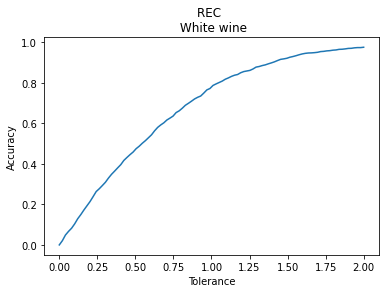

In [132]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,X_TEST_white,Y_TEST_white,[9],LR=1e-1/2,BN=False,STEP_SIZE=100000,DECAY=0.5,EPOCH=60000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_TRAIN"]
LOSS_validation_white=result_white["LOSS_VALIDATION"]
ACCURACY_WHITE_TRAIN=result_white["ACCURACY_TRAIN"]
ACCURACY_WHITE_VALIDATION=result_white["ACCURACY_VALIDATION"]

T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test Loss is {};".format(round(Result_TEST_white["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

Text(0.5, 1.0, 'White Wine \n Final Train Accuracy (T=1) = 81.052% \n Final Validation Accuracy (T=1) = 77.610%')

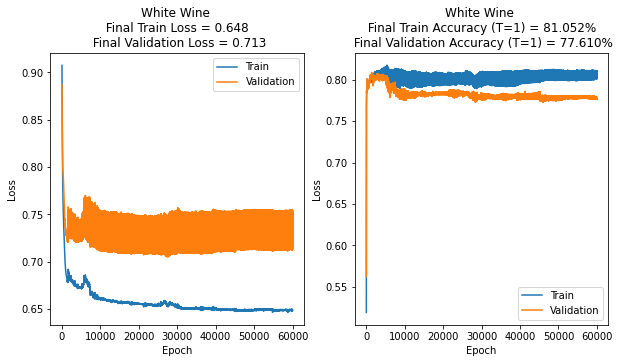

In [133]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
zoom=np.floor(len(LOSS_white)/900).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_white)-zoom)+zoom, LOSS_white[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_white)-zoom)+zoom, LOSS_validation_white[zoom:],label="Validation")

#plt.plot((np.arange(len(LOSS_validation_white))+1)*len(LOSS_white)-1, LOSS_validation_white,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("White Wine \n Final Train Loss = {:.3f} \n Final Validation Loss = {:.3f}".format(LOSS_white[-1],LOSS_validation_white[-1]))

plt.subplot(1,2,2)
zoom=np.floor(len(ACCURACY_WHITE_TRAIN)/9000).astype(int)
#zoom=0
plt.plot(np.arange(len(ACCURACY_WHITE_TRAIN)-zoom)+zoom, ACCURACY_WHITE_TRAIN[zoom:],label="Train")
plt.plot(np.arange(len(ACCURACY_WHITE_VALIDATION)-zoom)+zoom, ACCURACY_WHITE_VALIDATION[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("White Wine \n Final Train Accuracy (T=1) = {:.3f}% \n Final Validation Accuracy (T=1) = {:.3f}%".format(100*ACCURACY_WHITE_TRAIN[-1],100*ACCURACY_WHITE_VALIDATION[-1]))


After 20000 Epochs:
Train Loss is 0.4107; Train Accuracy is 88.3465% (T=1);
Test Loss is 0.5358; Test Accuracy is 83.3866% (T=1);
After 40000 Epochs:
Train Loss is 0.4093; Train Accuracy is 88.189% (T=1);
Test Loss is 0.5334; Test Accuracy is 82.2684% (T=1);
After 60000 Epochs:
Train Loss is 0.4093; Train Accuracy is 88.189% (T=1);
Test Loss is 0.5334; Test Accuracy is 82.2684% (T=1);
After 80000 Epochs:
Train Loss is 0.4093; Train Accuracy is 88.189% (T=1);
Test Loss is 0.5334; Test Accuracy is 82.2684% (T=1);
After 100000 Epochs:
Train Loss is 0.4093; Train Accuracy is 88.189% (T=1);
Test Loss is 0.5334; Test Accuracy is 82.2684% (T=1);
Test Loss is 0.533;
Test Accuracy is 26.997% (T=0.25);
Test Accuracy is 54.473% (T=0.5);
Test Accuracy is 82.268% (T=1);
Test KAPPA is 37.67% (T=0.5);


Text(0.5, 1.0, 'REC \n Red wine')

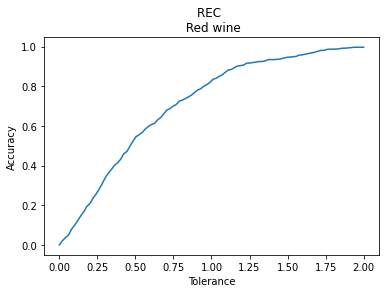

In [134]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,X_TEST_red,Y_TEST_red,[9],LR=1e-1/2,OPT="SGD",DROP_PR=0.0,BN=False,STEP_SIZE=30000,DECAY=0.5,EPOCH=100000,seed=233)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_TRAIN"]
LOSS_validation_red=result_red["LOSS_VALIDATION"]
ACCURACY_RED_TRAIN=result_red["ACCURACY_TRAIN"]
ACCURACY_RED_VALIDATION=result_red["ACCURACY_VALIDATION"]

T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test Loss is {};".format(round(Result_TEST_red["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))


T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n Red wine")

Text(0.5, 1.0, 'Red Wine \n Final Train Accuracy (T=1) = 88.189% \n Final Validation Accuracy (T=1) = 82.268%')

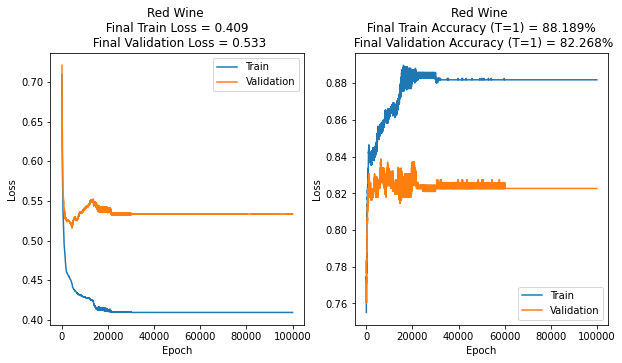

In [135]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
zoom=np.floor(len(LOSS_red)/3000).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_red)-zoom)+zoom, LOSS_red[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_red)-zoom)+zoom, LOSS_validation_red[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Red Wine \n Final Train Loss = {:.3f} \n Final Validation Loss = {:.3f}".format(LOSS_red[-1],LOSS_validation_red[-1]))

plt.subplot(1,2,2)
zoom=np.floor(len(ACCURACY_RED_TRAIN)/3000).astype(int)
#zoom=0
plt.plot(np.arange(len(ACCURACY_RED_TRAIN)-zoom)+zoom, ACCURACY_RED_TRAIN[zoom:],label="Train")
plt.plot(np.arange(len(ACCURACY_RED_VALIDATION)-zoom)+zoom, ACCURACY_RED_VALIDATION[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Red Wine \n Final Train Accuracy (T=1) = {:.3f}% \n Final Validation Accuracy (T=1) = {:.3f}%".format(100*ACCURACY_RED_TRAIN[-1],100*ACCURACY_RED_VALIDATION[-1]))


In [136]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())[:,0]
red_pred=np.where(red_pred >=8.0, 8, red_pred)
red_pred=np.where(red_pred <=3.0, 3, red_pred)  
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class)
print("Confusion Matrix for Red Wine (T=0.5)")
red_confusion 

Confusion Matrix for Red Wine (T=0.5)


,3,4,5,6,7,8
3,4,5,1,0,0,0
4,2,26,22,3,0,0
5,13,74,441,141,12,0
6,0,16,188,329,103,2
7,0,1,12,80,102,4
8,0,0,0,1,8,9


In [137]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())[:,0]
white_pred=np.where(white_pred >=8.0, 8, white_pred)
white_pred=np.where(white_pred <=3.0, 3, white_pred)
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
print("Confusion Matrix for White Wine (T=0.5)")

white_confusion 

Confusion Matrix for White Wine (T=0.5)


,3,4,5,6,7,8,9
3,2,9,7,2,0,0,0
4,2,32,98,28,3,0,0
5,4,89,914,418,32,0,0
6,0,33,661,1218,273,13,0
7,0,1,72,486,295,26,0
8,0,0,6,88,74,7,0
9,0,0,0,0,0,5,0


In [138]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    predictor=X_red_torch[(Y_red_torch==red_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[1.0])["accuracy_list"][0]
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2
print("Precision for different classes \n (Red Wine)")

red_precision.append(overall)

Precision for different classes 
 (Red Wine)


,T=0.5 (%),T=1.0 (%)
3,40,60
4,49.0566,75.4717
5,64.7577,88.3994
6,51.5674,85.4232
7,51.2563,79.397
8,50,72.2222
Overall,56.9731,85.3033


In [139]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    predictor=X_white_torch[(Y_white_torch==white_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[1.0])["accuracy_list"][0]
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2
print("Precision for different classes \n (White Wine)")

white_precision.append(overall)

Precision for different classes 
 (White Wine)


,T=0.5 (%),T=1.0 (%)
3,5,30
4,19.6319,53.3742
5,62.7316,89.4303
6,55.414,87.3521
7,33.5227,70.5682
8,2.85714,20.5714
9,40,80
Overall,50.3675,81.1964


## resample all classes but the majority class

In [140]:
counter = Counter(Y_white["quality"])
print(counter)
sm = SMOTE(sampling_strategy="not majority",random_state=24,k_neighbors=4)
Augmented_X_white,Augmented_Y_white=sm.fit_sample(X_white, Y_white["quality"])
counter = Counter(Augmented_Y_white)
print(counter)

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})
Counter({6: 2198, 5: 2198, 7: 2198, 8: 2198, 4: 2198, 3: 2198, 9: 2198})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [141]:
counter = Counter(Y_red["quality"])
print(counter)
sm = SMOTE(sampling_strategy="not majority",random_state=24,k_neighbors=4)
Augmented_X_red,Augmented_Y_red=sm.fit_sample(X_red, Y_red["quality"])
counter = Counter(Augmented_Y_red)
print(counter)

Counter({5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10})
Counter({5: 681, 6: 681, 7: 681, 4: 681, 8: 681, 3: 681})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [142]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(Augmented_X_white, Augmented_Y_white, test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(Augmented_X_red, Augmented_Y_red, test_size=0.33, random_state=42)
#X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(X_white, Y_white['quality'], test_size=0.33, random_state=42,stratify=Y_white['quality']) #24
#X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(X_red, Y_red['quality'], test_size=0.33, random_state=42,stratify=Y_red["quality"])

TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))

TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))

Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)

Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

"""scaler_white = preprocessing.StandardScaler().fit(X_white)
scaler_red = preprocessing.StandardScaler().fit(X_red)
X_white_torch = TO_TORCH(scaler_white.transform(X_white))
X_red_torch = TO_TORCH(scaler_red.transform(X_red))
Y_white_torch = TO_TORCH(Y_white)
Y_red_torch = TO_TORCH(Y_red)"""

'scaler_white = preprocessing.StandardScaler().fit(X_white)\nscaler_red = preprocessing.StandardScaler().fit(X_red)\nX_white_torch = TO_TORCH(scaler_white.transform(X_white))\nX_red_torch = TO_TORCH(scaler_red.transform(X_red))\nY_white_torch = TO_TORCH(Y_white)\nY_red_torch = TO_TORCH(Y_red)'

After 12000 Epochs:
Train Loss is 0.776; Train Accuracy is 76.203% (T=1);
Test Loss is 0.8162; Test Accuracy is 76.3883% (T=1);
After 24000 Epochs:
Train Loss is 0.7746; Train Accuracy is 76.6395% (T=1);
Test Loss is 0.8128; Test Accuracy is 75.5612% (T=1);
After 36000 Epochs:
Train Loss is 0.7741; Train Accuracy is 76.6395% (T=1);
Test Loss is 0.8107; Test Accuracy is 75.9157% (T=1);
After 48000 Epochs:
Train Loss is 0.7734; Train Accuracy is 76.5813% (T=1);
Test Loss is 0.8105; Test Accuracy is 75.8369% (T=1);
After 60000 Epochs:
Train Loss is 0.7732; Train Accuracy is 76.1835% (T=1);
Test Loss is 0.8142; Test Accuracy is 76.1914% (T=1);
Test Loss is 0.814;
Test Accuracy is 29.716% (T=0.25);
Test Accuracy is 50.079% (T=0.5);
Test Accuracy is 76.191% (T=1);
Test KAPPA is 41.8% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

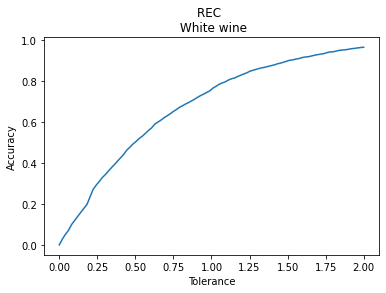

In [143]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,X_TEST_white,Y_TEST_white,[9],OPT="ADAM",LR=1e-1/2,BN=False,STEP_SIZE=20000,DECAY=0.5,EPOCH=60000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_TRAIN"]
LOSS_validation_white=result_white["LOSS_VALIDATION"]
ACCURACY_WHITE_TRAIN=result_white["ACCURACY_TRAIN"]
ACCURACY_WHITE_VALIDATION=result_white["ACCURACY_VALIDATION"]

T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test Loss is {};".format(round(Result_TEST_white["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

Text(0.5, 1.0, 'White Wine \n Final Train Accuracy (T=1) = 76.184% \n Final Validation Accuracy (T=1) = 76.191%')

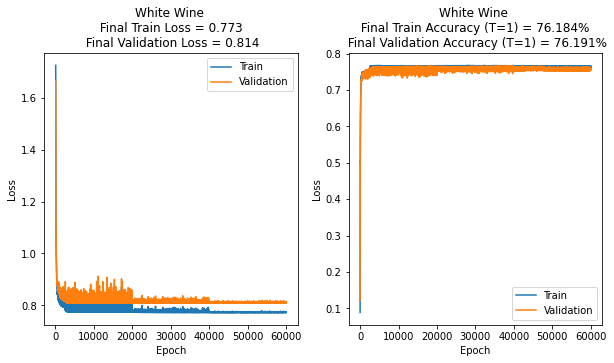

In [144]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
zoom=np.floor(len(LOSS_white)/900).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_white)-zoom)+zoom, LOSS_white[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_white)-zoom)+zoom, LOSS_validation_white[zoom:],label="Validation")

#plt.plot((np.arange(len(LOSS_validation_white))+1)*len(LOSS_white)-1, LOSS_validation_white,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("White Wine \n Final Train Loss = {:.3f} \n Final Validation Loss = {:.3f}".format(LOSS_white[-1],LOSS_validation_white[-1]))

plt.subplot(1,2,2)
zoom=np.floor(len(ACCURACY_WHITE_TRAIN)/9000).astype(int)
#zoom=0
plt.plot(np.arange(len(ACCURACY_WHITE_TRAIN)-zoom)+zoom, ACCURACY_WHITE_TRAIN[zoom:],label="Train")
plt.plot(np.arange(len(ACCURACY_WHITE_VALIDATION)-zoom)+zoom, ACCURACY_WHITE_VALIDATION[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("White Wine \n Final Train Accuracy (T=1) = {:.3f}% \n Final Validation Accuracy (T=1) = {:.3f}%".format(100*ACCURACY_WHITE_TRAIN[-1],100*ACCURACY_WHITE_VALIDATION[-1]))


After 20000 Epochs:
Train Loss is 0.367; Train Accuracy is 90.4275% (T=1);
Test Loss is 0.4816; Test Accuracy is 86.1379% (T=1);
After 40000 Epochs:
Train Loss is 0.3669; Train Accuracy is 90.4275% (T=1);
Test Loss is 0.4809; Test Accuracy is 86.0638% (T=1);
After 60000 Epochs:
Train Loss is 0.3669; Train Accuracy is 90.4275% (T=1);
Test Loss is 0.4809; Test Accuracy is 86.0638% (T=1);
After 80000 Epochs:
Train Loss is 0.3669; Train Accuracy is 90.4275% (T=1);
Test Loss is 0.4809; Test Accuracy is 86.0638% (T=1);
After 100000 Epochs:
Train Loss is 0.3669; Train Accuracy is 90.4275% (T=1);
Test Loss is 0.4809; Test Accuracy is 86.0638% (T=1);
Test Loss is 0.481;
Test Accuracy is 34.248% (T=0.25);
Test Accuracy is 61.231% (T=0.5);
Test Accuracy is 86.064% (T=1);
Test KAPPA is 53.464% (T=0.5);


Text(0.5, 1.0, 'REC \n Red wine')

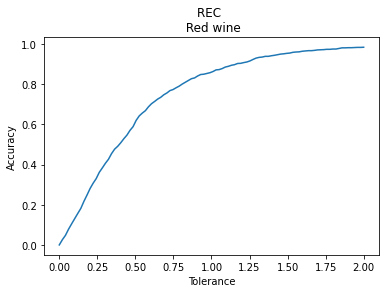

In [145]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,X_TEST_red,Y_TEST_red,[9],LR=1e-1/2,OPT="SGD",DROP_PR=0.0,BN=False,STEP_SIZE=30000,DECAY=0.5,EPOCH=100000,seed=233)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_TRAIN"]
LOSS_validation_red=result_red["LOSS_VALIDATION"]
ACCURACY_RED_TRAIN=result_red["ACCURACY_TRAIN"]
ACCURACY_RED_VALIDATION=result_red["ACCURACY_VALIDATION"]

T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test Loss is {};".format(round(Result_TEST_red["L2"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))


T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n Red wine")

Text(0.5, 1.0, 'Red Wine \n Final Train Accuracy (T=1) = 90.427% \n Final Validation Accuracy (T=1) = 86.064%')

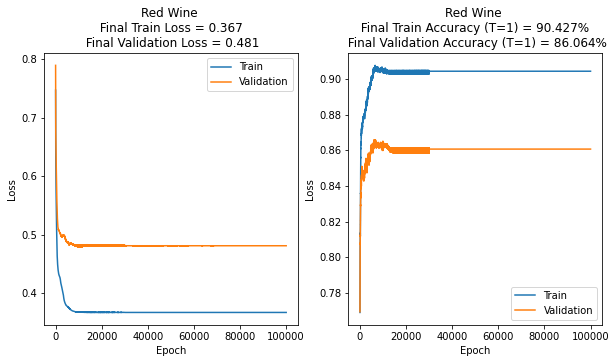

In [146]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
zoom=np.floor(len(LOSS_red)/3000).astype(int)
#zoom=0
plt.plot(np.arange(len(LOSS_red)-zoom)+zoom, LOSS_red[zoom:],label="Train")
plt.plot(np.arange(len(LOSS_validation_red)-zoom)+zoom, LOSS_validation_red[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Red Wine \n Final Train Loss = {:.3f} \n Final Validation Loss = {:.3f}".format(LOSS_red[-1],LOSS_validation_red[-1]))

plt.subplot(1,2,2)
zoom=np.floor(len(ACCURACY_RED_TRAIN)/3000).astype(int)
#zoom=0
plt.plot(np.arange(len(ACCURACY_RED_TRAIN)-zoom)+zoom, ACCURACY_RED_TRAIN[zoom:],label="Train")
plt.plot(np.arange(len(ACCURACY_RED_VALIDATION)-zoom)+zoom, ACCURACY_RED_VALIDATION[zoom:],label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Red Wine \n Final Train Accuracy (T=1) = {:.3f}% \n Final Validation Accuracy (T=1) = {:.3f}%".format(100*ACCURACY_RED_TRAIN[-1],100*ACCURACY_RED_VALIDATION[-1]))


In [147]:
red_pred=np.round(MODEL_NN_red(X_red_torch).cpu().detach().numpy())[:,0]
red_pred=np.where(red_pred >=8.0, 8, red_pred)
red_pred=np.where(red_pred <=3.0, 3, red_pred)  
red_confusion=confusion_matrix(Y_red_torch.cpu().detach().numpy(), red_pred)
red_confusion=pd.DataFrame(red_confusion,index=red_class,columns=red_class)
print("Confusion Matrix for Red Wine (T=0.5)")

red_confusion 

Confusion Matrix for Red Wine (T=0.5)


,3,4,5,6,7,8
3,7,2,1,0,0,0
4,9,26,16,2,0,0
5,43,154,302,145,33,4
6,5,69,172,186,167,39
7,0,3,14,35,107,40
8,0,0,0,0,2,16


In [148]:
white_pred=np.round(MODEL_NN_white(X_white_torch).cpu().detach().numpy())[:,0]
white_pred=np.where(white_pred >=8.0, 8, white_pred)
white_pred=np.where(white_pred <=3.0, 3, white_pred)
white_confusion=confusion_matrix(Y_white_torch.cpu().detach().numpy(), white_pred)
white_confusion=pd.DataFrame(white_confusion,index=white_class,columns=white_class) 
print("Confusion Matrix for White Wine (T=0.5)")

white_confusion 

Confusion Matrix for White Wine (T=0.5)


,3,4,5,6,7,8,9
3,16,0,3,1,0,0,0
4,61,35,47,9,11,0,0
5,143,263,651,289,88,23,0
6,83,186,618,625,483,203,0
7,24,30,91,207,300,228,0
8,5,3,9,21,68,69,0
9,0,0,0,0,0,5,0


In [149]:
red_precision=pd.DataFrame(index=red_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(red_class):
    label=Y_red_torch[Y_red_torch==red_class[i]]
    predictor=X_red_torch[(Y_red_torch==red_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_red,predictor,label,T_list=[1.0])["accuracy_list"][0]
    red_precision.at[c, "T=0.5 (%)"] = pre1
    red_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_red,X_red_torch,Y_red_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2
print("Precision for different classes \n (Red Wine)")

red_precision.append(overall)

Precision for different classes 
 (Red Wine)


,T=0.5 (%),T=1.0 (%)
3,70,80
4,49.0566,83.0189
5,44.3465,74.3025
6,29.1536,60.5016
7,53.7688,81.9095
8,83.3333,100
Overall,40.2126,70.3565


In [150]:
white_precision=pd.DataFrame(index=white_class,columns=["T=0.5 (%)","T=1.0 (%)"])
for i,c in enumerate(white_class):
    label=Y_white_torch[Y_white_torch==white_class[i]]
    predictor=X_white_torch[(Y_white_torch==white_class[i])[:,0],:]
    pre1=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[0.5])["accuracy_list"][0]
    pre2=100*TEST_NN(MODEL_NN_white,predictor,label,T_list=[1.0])["accuracy_list"][0]
    white_precision.at[c, "T=0.5 (%)"] = pre1
    white_precision.at[c, "T=1.0 (%)"] = pre2

overall=pd.DataFrame(index=["Overall"],columns=["T=0.5 (%)","T=1.0 (%)"])
pre1=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[0.5])["accuracy_list"][0]
pre2=100*TEST_NN(MODEL_NN_white,X_white_torch,Y_white_torch[:,0],T_list=[1.0])["accuracy_list"][0]
overall.at["Overall", "T=0.5 (%)"] = pre1
overall.at["Overall", "T=1.0 (%)"] = pre2
print("Precision for different classes \n (White Wine)")

white_precision.append(overall)

Precision for different classes 
 (White Wine)


,T=0.5 (%),T=1.0 (%)
3,40,55
4,21.4724,44.7853
5,44.6808,68.5655
6,28.4349,56.9609
7,34.0909,61.4773
8,29.1429,56
9,60,80
Overall,34.1568,60.8003


# To Be Continuted Conclusion

The Neural Network architecture is sick